# Simulation of a ring attractor network

**Aims**
- Implement a simulation of a ring attractor network
- Test if ring shaped attractor manifold can be recovered from simulated data

## Import statements

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
import sklearn.decomposition as skd
import networkx as nx

## Setting up simulation

In [112]:
# Make adjacency matrix
def make_adjacency_matrix(num_neurons, num_pos, asymmetry = False):
    adjacency_matrix = np.zeros((num_neurons, num_neurons))
    id_array = list(range(num_neurons)) + list(range(num_neurons)) + list(range(num_neurons)) 
    for i in range(num_neurons):
        for j in range(num_neurons):
            pos_set = id_array[num_neurons + i-num_pos:num_neurons + i+num_pos+1]
            neg_set_a = id_array[int(num_neurons + i - num_pos - (num_neurons - num_pos)/2):int(num_neurons + i - num_pos)+1]
            neg_set_b = id_array[int(num_neurons + i + num_pos + 1):int(num_neurons + i + num_pos + 1 + (num_neurons - num_pos)/2)]
            if i != j:
                if j in pos_set:
                    adjacency_matrix[i, j] = 2
                else:
                    if asymmetry:
                        if j in neg_set_a:
                            adjacency_matrix[i, j] = -1
                        elif j in neg_set_b:
                            adjacency_matrix[i, j] = -2
                    else:
                        adjacency_matrix[i, j] = -2
            else:
                adjacency_matrix[i, j] = 0
    return adjacency_matrix

In [113]:
num_neurons = 20
num_pos = 2

max_rate = 10

init_state = np.zeros(num_neurons)
init_state[num_neurons//2] = 1
id_array = list(range(num_neurons)) + list(range(num_neurons)) + list(range(num_neurons)) 
adjacency_matrix = make_adjacency_matrix(num_neurons, num_pos, asymmetry = False)

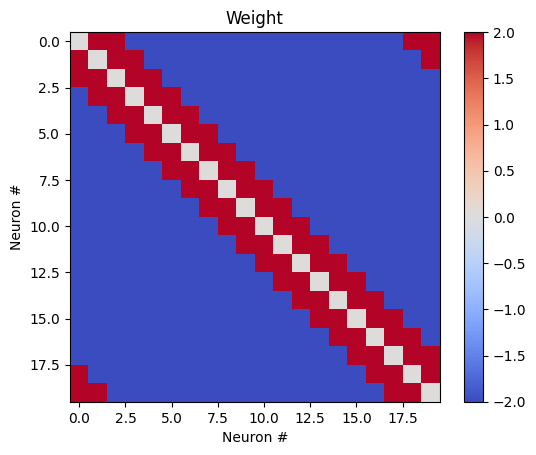

In [114]:
plt.imshow(adjacency_matrix, cmap='coolwarm', interpolation='nearest')
plt.xlabel("Neuron #")
plt.ylabel("Neuron #")
plt.title("Weight")
plt.colorbar()

Text(0.5, 1.0, 'Neural Network Graph')

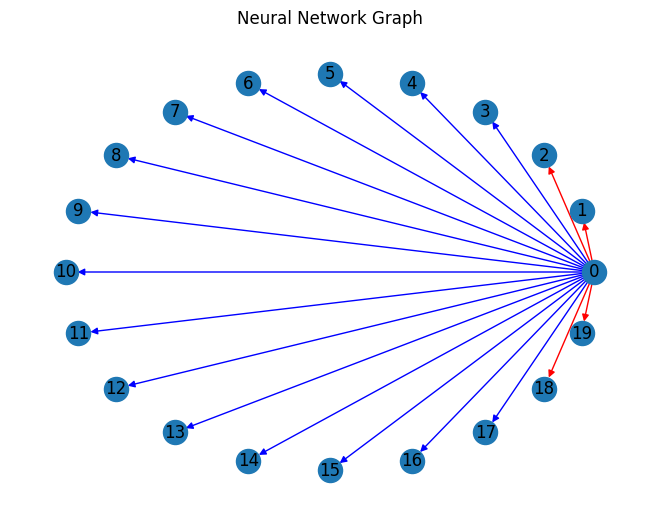

In [115]:
# make networkx graph
G = nx.DiGraph()
for i in range(1):
    for j in range(num_neurons):
        if adjacency_matrix[i, j] != 0:
            G.add_edge(i, j, color = 'r' if adjacency_matrix[i, j] > 0 else 'b', weight = adjacency_matrix[i, j])

# make networkx plot
plt.figure()
pos = nx.circular_layout(G)
colors = nx.get_edge_attributes(G, 'color').values()
nx.draw(G, pos, with_labels=True, edge_color=colors)
edge_labels = nx.get_edge_attributes(G, 'weight')
plt.title("Neural Network Graph")

In [116]:
# Cellular automata updator

def update_state(state, adjacency_matrix):
    new_state = np.zeros(len(state))
    for i in range(len(state)):
        change = np.sum([k*np.max([0, state[index]]) for index, k in enumerate(adjacency_matrix[i])])/len(state)
        if change > 0:
            new_state[i] = state[i] + change * ((max_rate - state[i])/max_rate)**2
        else:
            new_state[i] = state[i] + change 
        new_state[i] = np.max([0, new_state[i]])
        if new_state[i] > max_rate:
            new_state[i] = max_rate
    return new_state

In [117]:

def update_state(state, adjacency_matrix, max_rate):
    # Calculate the change
    positive_state = np.maximum(0, state)
    changes = np.dot(adjacency_matrix, positive_state) / len(state)

    # Update the state
    new_state = state + changes * np.where(changes > 0, ((max_rate - state) / max_rate) ** 2, 1)

    # Clip the state values
    new_state = np.clip(new_state, 0, max_rate)
    
    return new_state

## Run the simulation

In [118]:
# Simulation parameters
cycles = 100
state = init_state

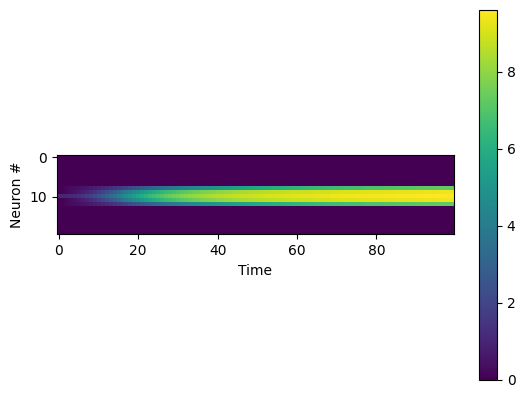

In [120]:
# Run the simulation
all_states = []
for i in range(cycles):
    all_states.append(state)
    #state += stimulation[:, i]
    state = update_state(state, adjacency_matrix, max_rate)
    

all_states = np.array(all_states).T
plt.imshow(all_states, cmap='viridis', interpolation='nearest')
plt.xlabel("Time")
plt.ylabel("Neuron #")
plt.colorbar()

## Testing attractor network with stochastic starting states

In [121]:
# Run the simulation for many initial conditions
N = 1000
cycles = 200
all_states = []
for i in range(N):
    init_state = [np.random.rand()*max_rate for i in range(num_neurons)]
    state = np.array(init_state)
    for i in range(cycles):
        state = update_state(state, adjacency_matrix, max_rate)
    all_states.append(state)

Text(0, 0.5, 'Neuron #')

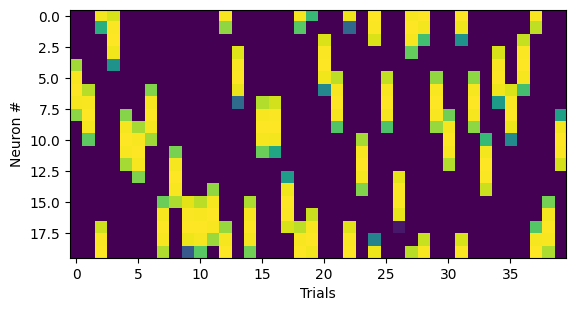

In [122]:
# Plot of convergence state for each trial
plt.imshow(np.array(all_states)[:num_neurons*2].T)
plt.xlabel('Trials')
plt.ylabel('Neuron #')

In [123]:
pca = skd.PCA(n_components = 2)
matrix = all_states.copy()
matrix_out = pca.fit_transform(matrix)

Text(0.5, 1.0, 'PCA plot of attractor states')

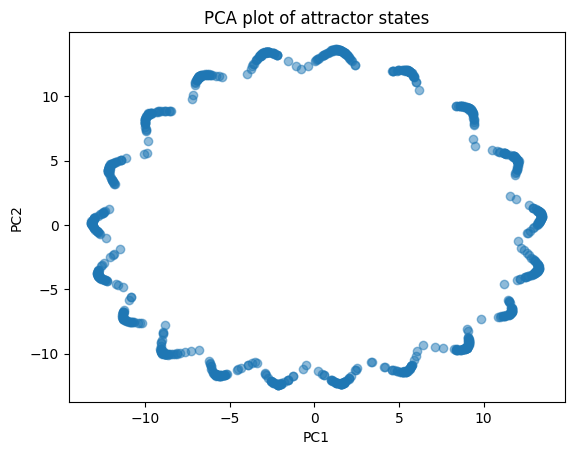

In [124]:
plt.plot(matrix_out[:, 0], matrix_out[:, 1], 'o', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA plot of attractor states")

## Applying a stimulus

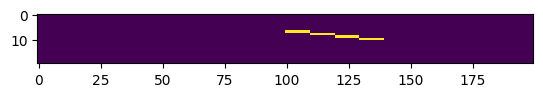

In [178]:
# sinusoid stimulus
stimulation = np.zeros((num_neurons, cycles))
counter = 0
for i in range(cycles):
    stimulation[id_array[int(counter)%num_neurons], i] = 0
    counter +=0.5


# point stimulus
stimulation = np.zeros((num_neurons, cycles))
stimulation[7, 100:110] = 10
stimulation[8, 110:120] = 10
stimulation[9, 120:130] = 10
stimulation[10, 130:140] = 10

plt.imshow(stimulation, cmap='viridis', interpolation='nearest')

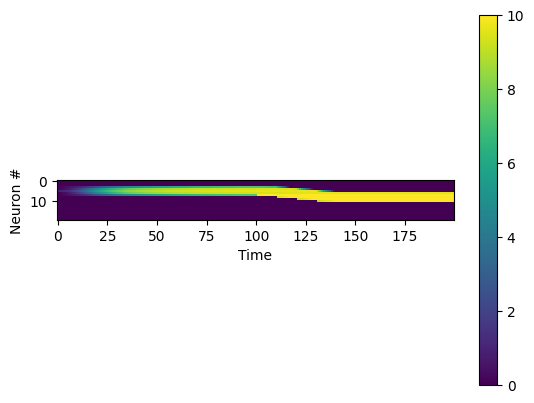

In [179]:
ccyles = 100

init_state = np.zeros(num_neurons)
init_state[5] = 1
state = np.array(init_state)
# Run the simulation
all_states = []
for i in range(cycles):
    all_states.append(state)
    state = np.array([state[n] if stimulation[n, i]==0 else stimulation[n, i] for n in range(num_neurons)])
    state = update_state(state, adjacency_matrix, max_rate)
    

all_states = np.array(all_states).T
plt.imshow(all_states, cmap='viridis', interpolation='nearest')
plt.xlabel("Time")
plt.ylabel("Neuron #")
plt.colorbar()